<a href="https://colab.research.google.com/github/sneakatyou/Tranformers-Tf2.0/blob/main/Transformers_TF_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tensorflow_datasets
!pip install -q tensorflow_text

     |████████████████████████████████| 3.4MB 5.5MB/s 


In [ ]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow.math as math
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_text as text

In [ ]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)

Data Loading

In [ ]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

In [ ]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  for pt in pt_examples.numpy():
      print(pt.decode('utf-8'))
  print("------------------------------")
  for en in en_examples.numpy():
      print(en.decode('utf-8'))

e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .
------------------------------
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [ ]:
model_name = "ted_hrlr_translate_pt_en_converter"
tf.keras.utils.get_file(
    f"{model_name}.zip",
    f"https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip",
    cache_dir='.', cache_subdir='', extract=True
)

188416/184801 [==============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [ ]:
tokenizers = tf.saved_model.load(model_name)

In [ ]:
tokenizers.en.vocab

<tf.Variable 'Variable:0' shape=(7010,) dtype=string, numpy=
array([b'[PAD]', b'[UNK]', b'[START]', ..., b'##\xe2\x80\x99',
       b'##\xe2\x99\xaa', b'##\xe2\x99\xab'], dtype=object)>

In [ ]:
tokenizers.pt.vocab

<tf.Variable 'Variable:0' shape=(7765,) dtype=string, numpy=
array([b'[PAD]', b'[UNK]', b'[START]', ..., b'##\xe2\x82\xac',
       b'##\xe2\x99\xaa', b'##\xe2\x99\xab'], dtype=object)>

In [ ]:
dir(tokenizers)[-7:]

['_update_uid',
 'en',
 'graph_debug_info',
 'pt',
 'signatures',
 'tensorflow_git_version',
 'tensorflow_version']

In [ ]:
dir(tokenizers.en)[-10:]

['_update_uid',
 '_vocab_path',
 'detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [ ]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [ ]:
encoded = tokenizers.en.tokenize(en_examples)
for row in encoded.to_list():
    print(row)

[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


In [ ]:
for en in en_examples.numpy():
  print(en.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [ ]:
encoded.shape

TensorShape([3, None])

In [ ]:
def tokenize_pairs(en,pt):
    pt = tokenizers.pt.tokenize(pt)
    en = tokenizers.en.tokenize(en)

    pt = pt.to_tensor()
    en = en.to_tensor()
    return en,pt

In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [ ]:
def make_batches(ds):
    return ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).map(tokenize_pairs,num_parallel_calls = tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)


#Positional Embeddings

In [ ]:
def get_angle(pos,i,d_model): #d_model = 512
    divisor = math.pow(tf.constant(10000,dtype=tf.float32),math.divide(math.multiply(tf.constant(2,tf.float32),i//2),tf.cast(d_model,tf.float32)))
    angle = math.divide(pos,divisor)
    return angle

In [ ]:

def get_positional_encoding(pos,d_model): #d_model = 512
    angle_final = get_angle(tf.expand_dims(tf.range(tf.cast(pos,tf.float32)),axis = 1),tf.expand_dims(tf.range(tf.cast(d_model,tf.float32)),axis = 0),d_model)
    np_angle_final = angle_final.numpy()
    np_angle_final[:,0::2] = np.sin(np_angle_final[:,0::2])
    np_angle_final[:,1::2] = np.cos(np_angle_final[:,1::2])
    angle_final = tf.convert_to_tensor(np_angle_final)
    pos_encoding = angle_final[tf.newaxis,...]
    return tf.cast(pos_encoding,dtype=tf.float32)


(1, 2048, 512)


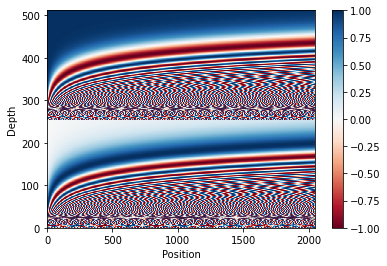

In [ ]:
n = tf.constant(2048.0,tf.float32)
d = tf.constant(512.0,tf.float32)
pos_encoding = get_positional_encoding(2048.0, 512.0)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2,1,0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

#Mask

In [ ]:
def generate_mask(seq):
    seq  = tf.cast(math.equal(seq,0),tf.float32)
    return seq[:,tf.newaxis,tf.newaxis,:]

In [ ]:
def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size,size)),-1,0)
    return mask

#Self Attention

In [ ]:
def Scaled_Dot_Product(q,k,v,mask,d_model):
    qk = tf.matmul(q,k,transpose_b = True)
    scaled_qk = tf.divide(qk,math.sqrt(tf.cast(d_model,tf.float32)))
    """print("---------------")
    print("shape before mask",scaled_qk.get_shape())
    print("shape of mask",mask.get_shape())
    print(scaled_qk.numpy())"""
    if mask is not None:
        scaled_qk += (mask*-1e9)
        """print("shape mask",scaled_qk.get_shape())"""
        
    attention_weights = tf.nn.softmax(scaled_qk,axis = -1)
    """print(attention_weights.numpy())"""
    final_output = tf.matmul(attention_weights,v)
    """print("---------------")"""
    return attention_weights,final_output


#Multi Head Attention

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,num_heads,d_model):
        super(MultiHeadAttention,self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = self.d_model//self.num_heads
        self.wq = tf.keras.layers.Dense(units = d_model)
        self.wk = tf.keras.layers.Dense(units = d_model)
        self.wv = tf.keras.layers.Dense(units = d_model)
        self.dense1 = tf.keras.layers.Dense(units = d_model)
    
    def split_into_heads(self,x,batch_size):
        #print("x shape is",x.get_shape())
        x = tf.reshape(x,(batch_size,-1,self.num_heads,self.depth))
        return tf.transpose(x,perm = [0,2,1,3])
    
    def call(self,q,k,v,mask):
        batch_size = tf.shape(q)[0]
        print(tf.shape(q))
        q = self.wq(q)
        k = self.wk(k)
        v = self.wq(v)
        
        #splitting into heads
        q = self.split_into_heads(q,batch_size)
        k = self.split_into_heads(k,batch_size)
        v = self.split_into_heads(v,batch_size)

        attention_weights,multi_head_output = Scaled_Dot_Product(q,k,v,mask,self.depth)

        pre_concat_multi_head_output =  tf.transpose(multi_head_output,perm = [0,2,1,3])
        post_concat_multi_head_output =  tf.reshape(pre_concat_multi_head_output,(batch_size,-1,self.d_model))
        
        final_output = self.dense1(post_concat_multi_head_output)
        return attention_weights,final_output


In [ ]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((64, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, y, y, mask=None)
out.shape, attn.shape

tf.Tensor([ 64  60 512], shape=(3,), dtype=int32)


(TensorShape([64, 8, 60, 60]), TensorShape([64, 60, 512]))

#Point wise feed forward network

In [ ]:
def Point_Wise_FeedForward_Net(d_model,hidden_layer_shape):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(hidden_layer_shape, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])
    

#Contructing Encoder Module

In [ ]:
class Encoding_Layer(tf.keras.layers.Layer):
    def __init__(self,num_heads,d_model,hidden_layer_shape,rate=0.1):
        super(Encoding_Layer,self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.multi_head_attention = MultiHeadAttention(num_heads,d_model)
        self.point_wise_ffd_net = Point_Wise_FeedForward_Net(d_model,hidden_layer_shape)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self,x,mask,training = True):
        #part1
        _,multihead_output = self.multi_head_attention(x,x,x,mask)
        dropout_multihead_output = self.dropout1(multihead_output,training = training)
        skip_dropout_output = tf.add(x,dropout_multihead_output)
        norm1_skip_output  = self.norm1(skip_dropout_output)        
        #part2
        point_norm1_output = self.point_wise_ffd_net(norm1_skip_output)
        dropout_point_output = self.dropout2(point_norm1_output,training = training)
        skip_dropout_output = tf.add(dropout_point_output,norm1_skip_output)
        norm2_skip_output = self.norm2(skip_dropout_output)
        return norm2_skip_output

In [ ]:
class Decoding_Layer(tf.keras.layers.Layer):
    def __init__(self,num_heads,d_model,hidden_layer_shape,rate = 0.1):
        super(Decoding_Layer,self).__init__()
        self.multi_head_attention1 = MultiHeadAttention(num_heads,d_model,)
        self.multi_head_attention2 = MultiHeadAttention(num_heads,d_model)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.norm3 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.point_ffd_net = Point_Wise_FeedForward_Net(d_model,hidden_layer_shape)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self,x,k,v,la_mask,pd_mask,training = False):
        _,multihead1_output = self.multi_head_attention1(x,x,x,la_mask)
        dropout1_multihead1_output = self.dropout1(multihead1_output)
        skip1_dropout1_output = tf.add(dropout1_multihead1_output,x)
        norm1_skip1_output = self.norm1(skip1_dropout1_output)

        _,multihead2_output  = self.multi_head_attention2(x,k,v,pd_mask)
        dropout2_multihead2_output = self.dropout2(multihead2_output)
        skip2_dropout2_output = tf.add(dropout2_multihead2_output,norm1_skip1_output)
        norm2_skip2_output = self.norm2(skip2_dropout2_output)

        point_norm2_output = self.point_ffd_net(norm2_skip2_output)
        dropout3_point_output = self.dropout3(point_norm2_output)
        skip3_dropout3_output = tf.add(norm2_skip2_output,dropout3_point_output)
        norm3_skip3_output = self.norm3(skip3_dropout3_output)
        return norm3_skip3_output

#Encoder

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self,d_model,num_heads,hidden_layer_shape,input_size, max_pos_encoding,num_enc_layers,rate = 0.1):
        super(Encoder,self).__init__()
        self.position_encoding = get_positional_encoding(max_pos_encoding,d_model)
        self.input_embedding = tf.keras.layers.Embedding(input_size,tf.cast(d_model,tf.int32))
        self.enc_layers = [Encoding_Layer(num_heads,d_model,hidden_layer_shape,rate) for _ in range(num_enc_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        self.d_model = d_model
        self.num_enc_layers = num_enc_layers
    def call(self,x,mask,training):
        seq_len = x.get_shape()[1]
        print(seq_len)
        embedding = self.input_embedding(x)
        #we multiply by sqrt(d) so as to increse the signal strength of input embedding, and 
        #thus reducing relative strength of positional encoding. so when we add both, we retain the 
        #information in the input embeddings
        scaled_embedding = math.multiply(embedding,math.sqrt(tf.cast(self.d_model,tf.float32)))
        pos_scaled_embedding = math.add(scaled_embedding,self.position_encoding[:,:seq_len,:])
        #print(pos_scaled_embedding.get_shape())

        output_input_encoder = self.dropout(pos_scaled_embedding,training = training)
        for i in range(self.num_enc_layers):
            output_input_encoder = self.enc_layers[i](output_input_encoder,mask,False)
        return output_input_encoder

In [ ]:
encoder = Encoder(tf.constant(512,tf.int32),tf.constant(8,tf.int32),tf.constant(2048,tf.int32),tf.constant(8500,tf.int32),tf.constant(10000,tf.int32),tf.constant(2,tf.int32))
input = tf.random.uniform((1,5),dtype=tf.int32,minval= 0,maxval=200)
mask = generate_mask(input)
output = encoder(input,mask,False)
print(output.shape)

5
tf.Tensor([  1   5 512], shape=(3,), dtype=int32)
tf.Tensor([  1   5 512], shape=(3,), dtype=int32)
(1, 5, 512)


#Decoder

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self,num_heads,d_model,hidden_layer_shape,max_position_encoding,num_layers,target_vocab_size,rate=0.1):
        super(Decoder,self).__init__()
        self.position_encoding = get_positional_encoding(max_position_encoding,d_model)
        self.d_model = d_model
        self.num_layers = num_layers
        self.input_embedding = tf.keras.layers.Embedding(target_vocab_size,d_model)
        self.decoder_layers = [Decoding_Layer(num_heads,d_model,hidden_layer_shape) for _ in tf.range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        self.num_layers = num_layers
    def call(self,x,encoder_output,look_ahead_mask,padding_mask,training = True):
        seq_len = tf.shape(x)[1]
        embedding = self.input_embedding(x)
        scaled_embedding = math.multiply(embedding,math.sqrt(tf.cast(self.d_model,tf.float32)))
        positional_encoding = self.position_encoding[:,:seq_len,:]
        pos_scaled_embedding = tf.add(positional_encoding,positional_encoding)
        
        output_input_decoder = self.dropout(pos_scaled_embedding,training = training)
        for i in range(self.num_layers):
            #print(i)
            output_input_decoder = self.decoder_layers[i](output_input_decoder,encoder_output,encoder_output,look_ahead_mask,padding_mask)
        
        return output_input_decoder

In [ ]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         hidden_layer_shape = 2048, target_vocab_size=8000,
                         max_position_encoding=5000)
temp_input = tf.random.uniform((1, 5), dtype=tf.int64, minval=0, maxval=200)
mask = generate_lookahead_mask(5)
pd_mask = generate_mask(temp_input)
output = sample_decoder(temp_input, 
                              encoder_output=output, 
                              training=False,
                              look_ahead_mask=mask, 
                              padding_mask=pd_mask)

output.shape

tf.Tensor([  1   5 512], shape=(3,), dtype=int32)
tf.Tensor([  1   5 512], shape=(3,), dtype=int32)
tf.Tensor([  1   5 512], shape=(3,), dtype=int32)
tf.Tensor([  1   5 512], shape=(3,), dtype=int32)


TensorShape([1, 5, 512])

#Transformer Model

---



In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self,num_layers,num_heads,d_model,hidden_layer_shape,target_vocab_size, pe_input,pe_target,input_vocab_size,rate = 0.1):
        super(Transformer,self).__init__()
        self.encoder = Encoder(d_model,num_heads,hidden_layer_shape,input_vocab_size,pe_input,num_layers,rate)
        self.decoder = Decoder(num_heads,d_model,hidden_layer_shape,pe_target,num_layers,target_vocab_size,rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self,input,target,enc_padding_mask,look_ahead_mask,dec_padding_mask,training = False):
        enc_output = self.encoder(input,enc_padding_mask,training)
        dec_output = self.decoder(target,enc_output,look_ahead_mask,dec_padding_mask,training)
        final_output = self.final_layer(dec_output)

        return final_output


In [ ]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, hidden_layer_shape =2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

tar_inp = temp_target[:,:-1]
enc_padding_mask, combined_mask, dec_padding_mask = create_masks(temp_input, tar_inp)
fn_out= sample_transformer(temp_input, tar_inp, training=False, 
                               enc_padding_mask = enc_padding_mask, 
                               look_ahead_mask = combined_mask,
                               dec_padding_mask = dec_padding_mask)

fn_out


#Training

---



In [ ]:
num_layers = 4
d_model = 128
hidden_layer_shape = 512
num_heads = 8
dropout_rate = 0.1
epochs = 20

In [ ]:
class LearningRateSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self,d_model,warmup_steps = 5000):
        super(LearningRateSchedule,self).__init__()
        self.d_model = tf.cast(d_model,tf.float32)
        self.warmup_steps = tf.cast(warmup_steps,tf.float32)
    
    def __call__(self,step):
        min_output = tf.minimum(math.rsqrt(step),step*math.pow(self.warmup_steps,tf.constant(-1.5,tf.float32)))
        learning_rate = math.rsqrt(self.d_model)*min_output
        return learning_rate
    

Text(0.5, 0, 'Train Step')

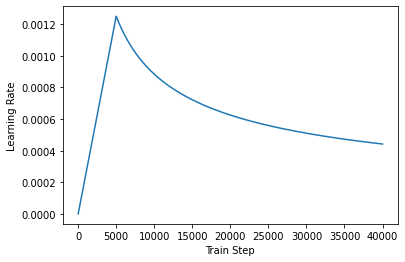

In [ ]:
temp_learning_rate_schedule = LearningRateSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
learning_rate = LearningRateSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate,beta_2=0.98,epsilon = 1e-9)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def loss_function(real,pred):
    mask = math.logical_not(math.equal(real,0))
    loss_ = loss_object(real,pred)
    mask = tf.cast(mask,dtype = loss_.dtype)
    loss_ = tf.multiply(mask,loss_)
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
def accuracy_function(real,pred):
    accuracy = math.equal(real,tf.argmax(pred,axis = 2))
    mask =   math.logical_not(math.equal(real,0))
    accuracy = math.logical_and(mask, accuracy)
    accuracy = tf.cast(accuracy, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    accuracy = tf.reduce_sum(accuracy)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [ ]:
transformer = Transformer(
    num_layers=num_layers, d_model=d_model, num_heads=num_heads, hidden_layer_shape =hidden_layer_shape, 
    input_vocab_size=tokenizers.pt.get_vocab_size(), target_vocab_size=tokenizers.en.get_vocab_size(), 
    pe_input=10000, pe_target=6000,rate = dropout_rate)

In [ ]:
def create_masks(input,target):
    encoder_mask = generate_mask(input)
    decoder_mask = generate_mask(input)
    look_ahead_mask = generate_lookahead_mask(tf.shape(target)[1])
    dec_target_mask = generate_mask(target)
    combined_mask = tf.maximum(look_ahead_mask,dec_target_mask)
    return encoder_mask,combined_mask,decoder_mask    

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

#Train function

In [ ]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]
@tf.function(input_signature=train_step_signature)
def train_step(input,target):
    tar_inp = target[:,:-1]
    tar_real = target[:,1:]
    encoder_mask,combined_mask,decoder_mask = create_masks(input,tar_inp)
    with tf.GradientTape() as tape:
        pred = transformer(input,tar_inp,encoder_mask,combined_mask,decoder_mask,True)
        print(pred)
        loss = loss_function(tar_real,pred)
    
    gradients = tape.gradient(loss,transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients,transformer.trainable_variables))
    train_loss(loss)
    train_accuracy(accuracy_function(tar_real,pred))


In [ ]:
for epoch in tf.range(epochs):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()

    for batch,(input,target) in enumerate(train_batches):
        train_step(input,target)
        if batch%10 == 0:
            print(f'--> Epoch {epoch+1} Batch {batch} Loss {train_loss.result(): .4f}')
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print (f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')
    
    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')  


#Masks for understanding

In [ ]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = generate_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = generate_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = generate_lookahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = generate_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

In [ ]:
tar = tf.random.uniform((2,5))
inp = tf.random.uniform((2,5))
enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar)

In [ ]:
enc_padding_mask

In [ ]:
combined_mask

In [ ]:
dec_padding_mask